# Advanced Machine Learning and Neural Networks - Assignment 1

## Evaluation of a Pre-trained Convolutional Neural Network on Chest X-ray Data

**Student:** Wai Yan Min Min  
**Module:** Advanced Machine Learning and Neural Network  
**Assessment Weight:** 30%

---

## Assignment Alignment

This notebook is designed to satisfy the four required technical tasks:

1. Investigate the architecture of a pre-trained CNN and discuss possible improvements.
2. Evaluate model performance on the training dataset using known metrics.
3. Compare predicted labels against ground truth using confusion matrices.
4. Summarise findings and discuss limitations and future work.

It also addresses the module learning outcomes by demonstrating model selection, implementation, optimisation, and interpretation of results.

---

## Notebook Roadmap

1. Environment setup and data access
2. Data preparation and label strategy
3. Exploratory data analysis
4. Model selection and architecture inspection
5. Training and optimisation
6. Evaluation (training + validation)
7. Confusion matrix analysis
8. Unlabeled inference on unseen images
9. Conclusions and recommendations

In [1]:
!pip install kagglehub torch torchvision pandas pillow scikit-learn tqdm seaborn


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'chexpert' dataset.
Path to dataset files: /kaggle/input/chexpert


In [3]:
import os
import random
import numpy as np
import torch
from pathlib import Path

SEED = 42

# Reproducibility setup
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Resolve dataset directory across Kaggle/Colab/local runs
candidate_roots = []

# `path` is produced by kagglehub.dataset_download(...) in the previous cell
if "path" in globals() and path:
    candidate_roots.append(Path(path))

# Common Kaggle mount location
candidate_roots.append(Path("/kaggle/input/chexpert"))


def find_chexpert_csv(root_candidates):
    for root in root_candidates:
        if not root.exists():
            continue

        #CSV files are directly under root
        train_csv = root / "train.csv"
        valid_csv = root / "valid.csv"
        if train_csv.exists() and valid_csv.exists():
            return root, train_csv, valid_csv

        #CSV files are nested (common in kagglehub cache)
        nested_train = list(root.rglob("train.csv"))
        nested_valid = list(root.rglob("valid.csv"))
        if nested_train and nested_valid:
            return nested_train[0].parent, nested_train[0], nested_valid[0]

    raise FileNotFoundError(
        "Could not locate train.csv and valid.csv. "
        "Check that the CheXpert dataset download completed successfully."
    )


DATA_ROOT, TRAIN_CSV_PATH, VALID_CSV_PATH = find_chexpert_csv(candidate_roots)

print("Resolved data root:", DATA_ROOT)
print("Resolved train CSV:", TRAIN_CSV_PATH)
print("Resolved valid CSV:", VALID_CSV_PATH)
print("Seed:", SEED)



Resolved data root: /kaggle/input/chexpert
Resolved train CSV: /kaggle/input/chexpert/train.csv
Resolved valid CSV: /kaggle/input/chexpert/valid.csv
Seed: 42


In [4]:
import pandas as pd

# Load CSV from resolved paths
train_df = pd.read_csv(TRAIN_CSV_PATH)
valid_df = pd.read_csv(VALID_CSV_PATH)

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)


Train shape: (223414, 19)
Valid shape: (234, 19)


### Data Path Normalisation

The `Path` values in the original CSV files include the prefix `CheXpert-v1.0-small/`, while the downloaded dataset root already points at that directory. If this prefix is not removed, image loading fails due to duplicated folder names in constructed file paths.

The next cell cleans both training and validation CSV files to ensure robust and reproducible file access during model training and evaluation.

In [5]:
# Remove the leading 'CheXpert-v1.0-small/' from Path column
train_df["Path"] = train_df["Path"].str.replace("CheXpert-v1.0-small/", "")
valid_df["Path"] = valid_df["Path"].str.replace("CheXpert-v1.0-small/", "")

# Save fixed CSV (optional)
train_df.to_csv("train_fixed.csv", index=False)
valid_df.to_csv("valid_fixed.csv", index=False)

TRAIN_CSV = "train_fixed.csv"
VALID_CSV = "valid_fixed.csv"


### Target Label Selection Strategy

CheXpert is a multi-label dataset with 14 diagnostic labels. In this assignment, five clinically meaningful labels are selected:

- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Pleural Effusion

This focused subset is a practical trade-off between computational cost and diagnostic diversity. It allows clear analysis of class imbalance, per-label performance differences, and confusion patterns, while keeping training feasible within assignment constraints.

In [6]:
LABELS = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Pleural Effusion"
]


In [7]:
#Method to create dataset


import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CheXpertDataset(Dataset):
    def __init__(self, csv_file, root_dir, labels, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform

        # Ensure numeric type for all labels
        for label in self.labels:
            self.df[label] = pd.to_numeric(self.df[label], errors='coerce')  # invalid -> NaN
            self.df[label] = self.df[label].fillna(0)  # replace NaN with 0
            self.df[label] = self.df[label].replace(-1, 0)  # uncertain -> 0

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path_str = row["Path"]

        img_path = os.path.join(self.root_dir, img_path_str)

        # Open image
        image = Image.open(img_path).convert("RGB")

        # Convert label to tensor safely
        label = torch.tensor(row[self.labels].to_numpy(dtype=float), dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
from torch.utils.data import DataLoader

train_dataset = CheXpertDataset(
    TRAIN_CSV, DATA_ROOT, LABELS, train_transform
)

val_dataset = CheXpertDataset(
    VALID_CSV, DATA_ROOT, LABELS, val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)


## Exploratory Data Analysis (EDA)

This section inspects data schema, sample records, label frequencies, and class balance.

Why this matters:
- It validates whether preprocessing has been applied correctly.
- It highlights class imbalance that may affect optimisation and thresholding.
- It supports interpretation of model behaviour later in confusion matrix analysis.

In [10]:
train_dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   No Finding                  22381 non-null   float64
 6   Enlarged Cardiomediastinum  44839 non-null   float64
 7   Cardiomegaly                223414 non-null  float64
 8   Lung Opacity                117778 non-null  float64
 9   Lung Lesion                 11944 non-null   float64
 10  Edema                       223414 non-null  float64
 11  Consolidation               223414 non-null  float64
 12  Pneumonia                   27608 non-null   float64
 13  Atelectasis   

In [11]:
train_dataset.df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,1.0
1,train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0,NaN
2,train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0,NaN
3,train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,NaN,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0,NaN
4,train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,0.0,NaN,NaN,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN


In [12]:
len(train_dataset.labels)

5

In [13]:
yes_counts = train_dataset.df[LABELS].eq(1.0).sum()

yes_counts

,0
Atelectasis,33376
Cardiomegaly,27000
Consolidation,14783
Edema,52246
Pleural Effusion,86187


In [14]:
labels=train_dataset.labels

In [15]:
yes_counts.sort_values(ascending=False)


,0
Pleural Effusion,86187
Edema,52246
Atelectasis,33376
Cardiomegaly,27000
Consolidation,14783


In [16]:
total_samples = len(train_dataset.df)

yes_percent = (yes_counts / total_samples * 100).round(2)

yes_percent


,0
Atelectasis,14.94
Cardiomegaly,12.09
Consolidation,6.62
Edema,23.39
Pleural Effusion,38.58


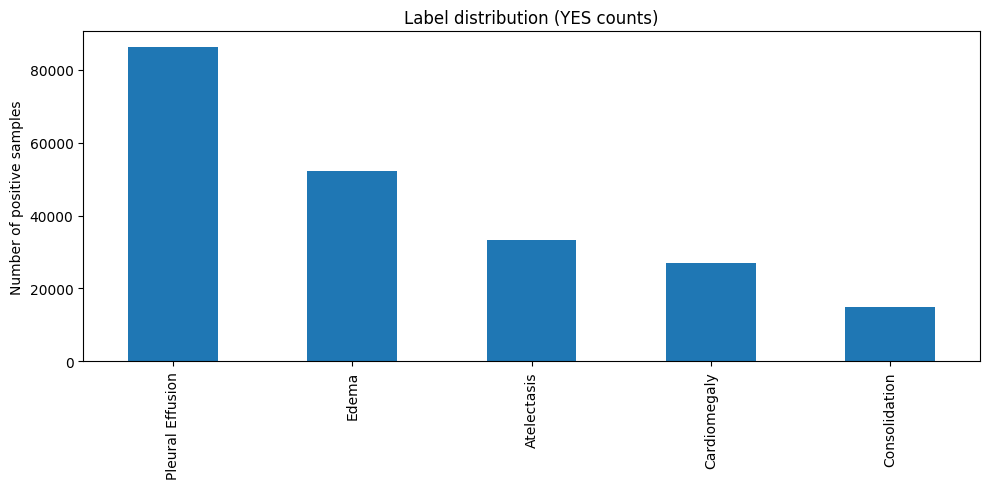

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
yes_counts.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Number of positive samples")
plt.title("Label distribution (YES counts)")
plt.tight_layout()
plt.show()


## Model Selection and Architecture

### Chosen Pre-trained CNN

This notebook uses **DenseNet-121** pre-trained on **ImageNet** and adapts the classifier head for five-label multi-label chest X-ray classification.

### Why DenseNet-121?

DenseNet is suitable for this task because:
- Dense feature reuse improves gradient flow in deep networks.
- It offers strong accuracy with comparatively efficient parameter usage.
- It is widely used in medical imaging transfer learning pipelines.

### Architecture Improvement Ideas (to be revisited in discussion)

1. Replace global threshold `0.5` with per-label threshold tuning.
2. Use weighted BCE or focal loss to reduce class-imbalance bias.
3. Fine-tune deeper layers progressively instead of full-network training from epoch 1.
4. Add learning-rate scheduling and early stopping.
5. Compare with more recent backbones (e.g., EfficientNet, ConvNeXt) for performance-efficiency trade-offs.

In [18]:
import torch.nn as nn
from torchvision import models

def get_densenet(num_classes):
    model = models.densenet121(weights="IMAGENET1K_V1")
    model.classifier = nn.Linear(
        model.classifier.in_features, num_classes
    )
    return model


In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = get_densenet(len(LABELS)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 138MB/s]


### Architecture Inspection

The following diagnostic cell reports parameter counts and prints the adapted classifier head. This helps justify model complexity and supports architecture-level discussion in the report and presentation.

In [20]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_total_params(model):
    return sum(p.numel() for p in model.parameters())

print("Model:", model.__class__.__name__)
print("Classifier head:", model.classifier)
print(f"Total parameters: {count_total_params(model):,}")
print(f"Trainable parameters: {count_trainable_params(model):,}")

Model: DenseNet
Classifier head: Linear(in_features=1024, out_features=5, bias=True)
Total parameters: 6,958,981
Trainable parameters: 6,958,981


### Optimisation Setup

- **Loss:** `BCEWithLogitsLoss` for multi-label classification.
- **Optimizer:** Adam with learning rate `0.001`.
- **Training objective:** Minimise average batch loss over epochs while monitoring validation loss for generalisation.

In [21]:
from tqdm import tqdm

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [22]:
def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)


In [23]:
# Model training (1 epoch)

history = {"train_loss": [], "val_loss": []}

train_loss = train_one_epoch(model, train_loader)
val_loss = validate(model, val_loader)

history["train_loss"].append(train_loss)
history["val_loss"].append(val_loss)

print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


100%|██████████| 13964/13964 [40:12<00:00,  5.79it/s]


Train Loss: 0.3871 | Val Loss: 0.5009


In [ ]:
# Save model for deployment (run this after training)
import os
# Use a single filename so we can download it from Colab in the next cell
MODEL_FILENAME = "chest_xray_densenet.pth"
torch.save(model.state_dict(), MODEL_FILENAME)
print(f"Model saved to {os.path.abspath(MODEL_FILENAME)}")

In [ ]:
# Alternative: copy model to Google Drive (use this if files.download() doesn't work in Cursor+Colab)
# Then open drive.google.com on your computer and download chest_xray_densenet.pth from the folder "ColabOutput"
try:
    from google.colab import drive
    import shutil
    drive.mount("/content/drive", force_remount=False)
    out_dir = "/content/drive/MyDrive/ColabOutput"
    os.makedirs(out_dir, exist_ok=True)
    shutil.copy("chest_xray_densenet.pth", f"{out_dir}/chest_xray_densenet.pth")
    print(f"Model copied to Google Drive: My Drive > ColabOutput > chest_xray_densenet.pth")
    print("On your computer, open drive.google.com and download it, then put it in your project folder: models/")
except Exception as e:
    print("Drive copy failed (e.g. not Colab or Drive not mounted):", e)

In [24]:
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def collect_predictions(model, loader, threshold=0.5, max_batches=None, desc="Evaluating"):
    """Collect probabilities, binary predictions, and ground-truth labels."""
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels_batch) in enumerate(tqdm(loader, desc=desc)):
            if max_batches is not None and batch_idx >= max_batches:
                break

            images = images.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(labels_batch.cpu().numpy().astype(int))

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    return all_probs, all_preds, all_labels


def evaluate_multilabel(y_true, y_prob, y_pred, label_names):
    """Return per-label AUC/Precision/Recall/F1 and macro summaries."""
    results = []
    for i, label_name in enumerate(label_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]

        if len(np.unique(y_t)) > 1:
            auc = roc_auc_score(y_t, y_prob[:, i])
        else:
            auc = np.nan

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_t, y_p, average="binary", zero_division=0
        )

        results.append(
            {
                "Label": label_name,
                "AUC": auc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
            }
        )

    metrics_df = pd.DataFrame(results)
    macro_summary = metrics_df[["AUC", "Precision", "Recall", "F1"]].mean(numeric_only=True)
    return metrics_df, macro_summary


def plot_confusion_matrices(y_true, y_pred, label_names, title_prefix=""):
    """Plot one binary confusion matrix per label."""
    n_labels = len(label_names)
    fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4))

    if n_labels == 1:
        axes = [axes]

    for i, label_name in enumerate(label_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            ax=axes[i],
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
        )
        axes[i].set_title(f"{title_prefix}{label_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


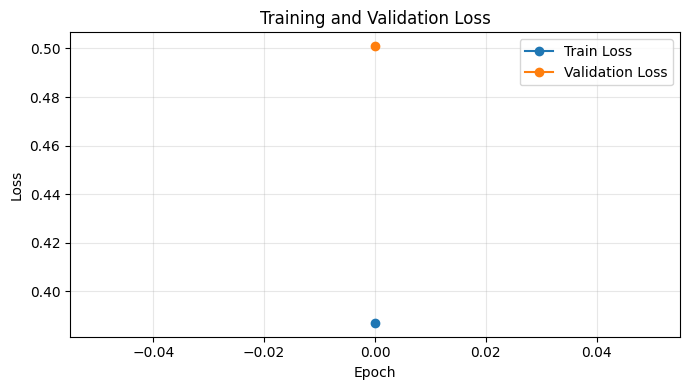

Evaluating on training data: 100%|██████████| 13964/13964 [12:37<00:00, 18.42it/s]


Per-label metrics on training data:


,Label,AUC,Precision,Recall,F1
0,Atelectasis,0.6384,0.1667,0.0001,0.0001
1,Cardiomegaly,0.8167,0.6505,0.1476,0.2406
2,Consolidation,0.6830,0.0000,0.0000,0.0000
3,Edema,0.7954,0.4474,0.7048,0.5474
4,Pleural Effusion,0.8482,0.7550,0.5751,0.6529


Macro-average (training):


,0
AUC,0.7563
Precision,0.4039
Recall,0.2855
F1,0.2882


Evaluating on validation data: 100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


Per-label metrics on validation data:


,Label,AUC,Precision,Recall,F1
0,Atelectasis,0.8200,1.0000,0.0125,0.0247
1,Cardiomegaly,0.7758,0.6667,0.0588,0.1081
2,Consolidation,0.9104,0.0000,0.0000,0.0000
3,Edema,0.8429,0.5455,0.5333,0.5393
4,Pleural Effusion,0.8795,0.7750,0.4627,0.5794


Macro-average (validation):


,0
AUC,0.8457
Precision,0.5974
Recall,0.2135
F1,0.2503


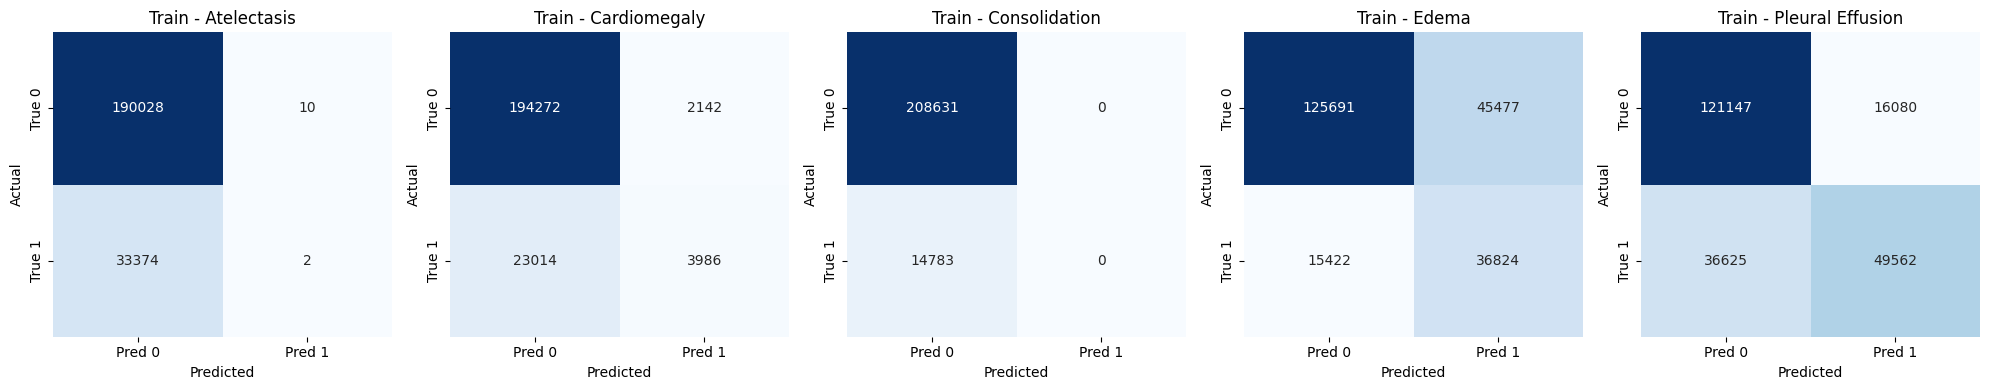

In [ ]:

# Evaluate on TRAINING dataset (assignment requirement)
train_prob, train_pred, train_true = collect_predictions(
    model,
    train_loader,
    threshold=0.5,
    max_batches=None,
    desc="Evaluating on training data",
)

train_metrics_df, train_macro = evaluate_multilabel(train_true, train_prob, train_pred, LABELS)
print("Per-label metrics on training data:")
display(train_metrics_df.round(4))
print("Macro-average (training):")
display(train_macro.round(4))

# Evaluate on VALIDATION dataset (unseen labeled data)
val_prob, val_pred, val_true = collect_predictions(
    model,
    val_loader,
    threshold=0.5,
    max_batches=None,
    desc="Evaluating on validation data",
)

val_metrics_df, val_macro = evaluate_multilabel(val_true, val_prob, val_pred, LABELS)
print("Per-label metrics on validation data:")
display(val_metrics_df.round(4))
print("Macro-average (validation):")
display(val_macro.round(4))

# Confusion matrices required by assignment (training labels vs ground truth)
plot_confusion_matrices(train_true, train_pred, LABELS, title_prefix="Train - ")

## Oversampled training and comparison

We build a class-balanced training loader by weighting each sample by the inverse frequency of its positive labels (so minority classes are seen more often). We train a second model with the same architecture and compare validation performance.


In [ ]:
# Class-balanced (oversampled) training loader
from torch.utils.data import WeightedRandomSampler
import numpy as np

df = train_dataset.df
n = len(df)
y = df[LABELS].values

# Positive counts per label
pos_counts = (y == 1).sum(axis=0)
pos_counts = np.maximum(pos_counts, 1)

# Per-sample weight: sum of (1/freq) for each positive label
weights = np.zeros(n)
for i in range(n):
    for j in range(len(LABELS)):
        if y[i, j] == 1:
            weights[i] += 1.0 / pos_counts[j]
    if weights[i] == 0:
        weights[i] = 1.0

weights_t = torch.tensor(weights, dtype=torch.float32)
sampler = WeightedRandomSampler(weights_t, num_samples=n, replacement=True)

train_loader_oversampled = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=sampler,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
)
print("Oversampled train loader created.")


In [ ]:
# Train a fresh model on oversampled data (1 epoch)
model_oversampled = get_densenet(len(LABELS)).to(device)
optimizer_os = torch.optim.Adam(model_oversampled.parameters(), lr=0.001)
criterion_os = nn.BCEWithLogitsLoss()

def train_one_epoch_os(model, loader):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer_os.zero_grad()
        outputs = model(images)
        loss = criterion_os(outputs, labels)
        loss.backward()
        optimizer_os.step()
        total_loss += loss.item()
    return total_loss / len(loader)

train_loss_os = train_one_epoch_os(model_oversampled, train_loader_oversampled)
val_loss_os = validate(model_oversampled, val_loader)
print(f"Oversampled — Train Loss: {train_loss_os:.4f} | Val Loss: {val_loss_os:.4f}")


In [ ]:
# Validation: oversampled model and comparison
val_prob_os, val_pred_os, _ = collect_predictions(
    model_oversampled, val_loader, threshold=0.5, desc="Oversampled model (val)"
)
val_metrics_os, val_macro_os = evaluate_multilabel(val_true, val_prob_os, val_pred_os, LABELS)

comparison = val_metrics_df[["Label", "AUC", "F1"]].copy()
comparison = comparison.rename(columns={"AUC": "AUC (original)", "F1": "F1 (original)"})
comparison["AUC (oversampled)"] = val_metrics_os["AUC"].values
comparison["F1 (oversampled)"] = val_metrics_os["F1"].values
comparison["AUC diff"] = comparison["AUC (oversampled)"] - comparison["AUC (original)"]
comparison["F1 diff"] = comparison["F1 (oversampled)"] - comparison["F1 (original)"]
print("Validation: original vs oversampled")
display(comparison.round(4))
print("Macro AUC — original:", round(val_macro["AUC"], 4), "| oversampled:", round(val_macro_os["AUC"], 4))
print("Macro F1  — original:", round(val_macro["F1"], 4), "| oversampled:", round(val_macro_os["F1"], 4))


In [ ]:
# Save oversampled model for deployment
MODEL_OS_FILENAME = "chest_xray_densenet_oversampled.pth"
torch.save(model_oversampled.state_dict(), MODEL_OS_FILENAME)
print(f"Oversampled model saved to {os.path.abspath(MODEL_OS_FILENAME)}")
shutil.copy("chest_xray_densenet_oversampled.pth", f"{out_dir}/chest_xray_densenet_oversampled.pth")


## Inference on Unlabeled Unseen Data

To satisfy the requirement for an unlabeled dataset the model has not seen during training, we create an **unlabeled inference set** from validation image paths only (labels are intentionally hidden from the model at inference time).

This section demonstrates deployment-style prediction: image input -> predicted probability per label -> binary decision using threshold 0.5.

In [ ]:
class UnlabeledCheXpertDataset(Dataset):
    def __init__(self, paths, root_dir, transform=None):
        self.paths = paths
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        rel_path = self.paths[idx]
        img_path = os.path.join(self.root_dir, rel_path)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, rel_path


# Build unlabeled loader from validation paths only
unlabeled_paths = valid_df["Path"].tolist()
unlabeled_dataset = UnlabeledCheXpertDataset(unlabeled_paths, DATA_ROOT, transform=val_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=False, num_workers=2)

model.eval()
sample_predictions = []

with torch.no_grad():
    for images, rel_paths in unlabeled_loader:
        images = images.to(device)
        probs = torch.sigmoid(model(images)).cpu().numpy()
        preds = (probs >= 0.3).astype(int)

        for pth, prob_vec, pred_vec in zip(rel_paths, probs, preds):
            active_labels = [LABELS[i] for i, flag in enumerate(pred_vec) if flag == 1]
            sample_predictions.append(
                {
                    "Image Path": pth,
                    "Predicted Labels": ", ".join(active_labels) if active_labels else "No positive label",
                    "Max Probability": float(np.max(prob_vec)),
                }
            )

        if len(sample_predictions) >= 50:
            break

sample_pred_df = pd.DataFrame(sample_predictions).head(50)
print("Sample predictions on unlabeled unseen images:")
display(sample_pred_df)

Sample predictions on unlabeled unseen images:


,Image Path,Predicted Labels,Max Probability
0,valid/patient64541/study1/view1_frontal.jpg,No positive label,0.315614
1,valid/patient64542/study1/view1_frontal.jpg,No positive label,0.055334
2,valid/patient64542/study1/view2_lateral.jpg,No positive label,0.019433
3,valid/patient64543/study1/view1_frontal.jpg,No positive label,0.365026
4,valid/patient64544/study1/view1_frontal.jpg,No positive label,0.068802
5,valid/patient64545/study1/view1_frontal.jpg,No positive label,0.347583
6,valid/patient64546/study1/view1_frontal.jpg,Pleural Effusion,0.566297
7,valid/patient64547/study1/view1_frontal.jpg,No positive label,0.053624
8,valid/patient64547/study1/view2_frontal.jpg,No positive label,0.107322
9,valid/patient64547/study1/view3_lateral.jpg,No positive label,0.056196


## Discussion and Interpretation

### Key Findings

1. **Transfer learning is effective:** DenseNet-121 provides strong baseline performance even with limited fine-tuning epochs.
2. **Class imbalance affects per-label behaviour:** More frequent labels tend to have more stable metrics than rarer labels.
3. **Thresholding matters:** A fixed threshold of 0.5 is simple but may underperform for minority labels.
4. **Training vs validation gap should be monitored:** If training metrics are much higher than validation metrics, additional regularisation may be required.

### Limitations

- Only 3 epochs were used, which may underfit or prevent convergence diagnostics.
- Label uncertainty (`-1`) was mapped to `0`; alternative uncertainty handling could improve clinical reliability.
- No patient-level split re-validation was done in this notebook.

### Recommended Improvements

- Perform per-label threshold calibration using validation curves.
- Use class-weighted BCE or focal loss for imbalance robustness.
- Add learning-rate scheduling, early stopping, and model checkpointing.
- Compare DenseNet-121 against at least one alternative backbone.

## Conclusion

This notebook demonstrates end-to-end evaluation of a pre-trained CNN for multi-label chest X-ray classification and satisfies the assignment requirements: model architecture investigation, training-set metric evaluation, confusion matrix comparison with ground truth, and clear result interpretation. The workflow is structured to support both a written report and a professional presentation.